## Aim

Compute an ABC occurrence rate estimate, and compare results with ```occurrence_mcmc```.

In [4]:
#!/bin/env python  
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
from scipy import optimize, stats, linalg
from utils import dfm
from utils.abc import ABCSampler
# import astroabc

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


My ABC setup requires

- a prior for the model parameters $\theta$, i.e. a ```stats.continuous_rv/stats.discrete_rv``` object whose .rvs() method returns candidate parameters.
- a sampler for $f(x \mid \theta)$
- distance and statistic functions
- data to fit

I'm not 100% sure how any of these work.

In [5]:
kois = dfm.get_kois()
stellar = dfm.stlr
kois = kois[kois["kepid"].isin(stellar["kepid"])]
# kois = dfm.kois_cuts(kois) - don't do the cuts! Not enough data to work with otherwise
# the only part of the cuts that is necessary is to get rid of NaN radii
kois = kois[np.isfinite(kois["koi_prad"])]

Text(0, 0.5, 'Counts')

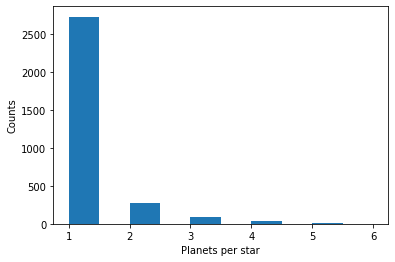

In [12]:
starcounts = np.array(pd.crosstab(index=kois['kepid'], columns="count")).flatten()
plt.hist(starcounts)
plt.xlabel("Planets per star")
plt.ylabel("Counts")

Now the dataset has sufficient complexity to fit a Poisson process.

In [17]:
assert np.all(np.isfinite(kois["koi_prad"]))
assert np.all(np.isfinite(kois["koi_period"]))
radii = kois["koi_prad"]
periods = kois["koi_period"]

In [15]:
lam = np.mean(pd.crosstab(index=kois['kepid'], columns="count"))
planet_numbers = np.minimum(stats.poisson(lam).rvs(size=(len(stellar),)), 10)        

(array([2.7371e+04, 3.3257e+04, 1.9791e+04, 7.8690e+03, 2.4330e+03,
        5.6200e+02, 1.3100e+02, 2.6000e+01, 5.0000e+00, 1.0000e+00]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

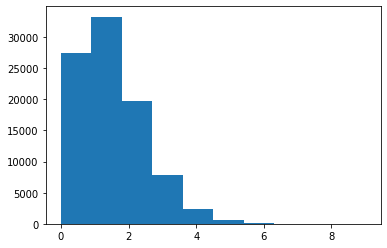

In [16]:
plt.hist(planet_numbers)

In [18]:
min_period, min_radius = min(periods), min(radii)
max_period, max_radius = max(periods), max(radii)
period_buckets = [min_period * 2 ** i for i in range(int(np.ceil(np.log2(max_period / min_period))))]
radius_buckets = [min_radius * 2 ** i for i in range(int(np.ceil(np.log2(max_radius / min_radius))))]